In [4]:
packrat::init("/work/postresearch/Shared/Projects/Farbod/CaseMix")
packrat::on()
packrat::status()

Initializing packrat project in directory:
- "/work/postresearch/Shared/Projects/Farbod/CaseMix"

Initialization complete!

Up to date.



In [5]:
install.packages(c("httr", "jsonlite"))

Installing packages into ‘/work/postresearch/Shared/Projects/Farbod/CaseMix/packrat/lib/x86_64-pc-linux-gnu/4.2.0’
(as ‘lib’ is unspecified)



In [6]:
library(httr)
library(jsonlite)
library(data.table)
library(dtplyr)

In [216]:
cms_data_importer=function(url,data_size){

  require(data.table)
  require(dplyr)
  require(httr)
  require(jsonlite)
  require(tidyverse)
  
  stats=GET(paste(url,"/stats",sep = ""))

  row_count=content(stats,as="parsed")$total_rows

  offset=0
  data=data.table()

  if(data_size=="all"){
    while(offset<row_count){
      new_get=GET(paste(url,"?size=5000&offset=",offset,sep = ""))
      new_data=fromJSON(rawToChar(new_get$content))
      data=rbind(data,new_data)
      offset=offset+5000
    }
  }
  else{
    while(offset<data_size){
      new_get=GET(paste(url,"?size=5000&offset=",offset,sep = ""))
      new_data=fromJSON(rawToChar(new_get$content))
      data=rbind(data,new_data)
      offset=offset+5000
    }
  }
  
  return(data%>%as.data.table())

}

In [218]:
physician_data=cms_data_importer(
  url = 
  "https://data.cms.gov/data-api/v1/dataset/14cd68c2-9433-4069-90fa-d213ef709661/data",
  data_size=100000
)

In [219]:
colnames(physician_data)

[1] "Rndrng_NPI"                    "Rndrng_Prvdr_Last_Org_Name"   
 [3] "Rndrng_Prvdr_First_Name"       "Rndrng_Prvdr_MI"              
 [5] "Rndrng_Prvdr_Crdntls"          "Rndrng_Prvdr_Gndr"            
 [7] "Rndrng_Prvdr_Ent_Cd"           "Rndrng_Prvdr_St1"             
 [9] "Rndrng_Prvdr_St2"              "Rndrng_Prvdr_City"            
[11] "Rndrng_Prvdr_State_Abrvtn"     "Rndrng_Prvdr_State_FIPS"      
[13] "Rndrng_Prvdr_Zip5"             "Rndrng_Prvdr_RUCA"            
[15] "Rndrng_Prvdr_RUCA_Desc"        "Rndrng_Prvdr_Cntry"           
[17] "Rndrng_Prvdr_Type"             "Rndrng_Prvdr_Mdcr_Prtcptg_Ind"
[19] "HCPCS_Cd"                      "HCPCS_Desc"                   
[21] "HCPCS_Drug_Ind"                "Place_Of_Srvc"                
[23] "Tot_Benes"                     "Tot_Srvcs"                    
[25] "Tot_Bene_Day_Srvcs"            "Avg_Sbmtd_Chrg"               
[27] "Avg_Mdcr_Alowd_Amt"            "Avg_Mdcr_Pymt_Amt"            
[29] "Avg_Mdcr_Stdzd_Amt"

In [220]:
physician_data=physician_data[,.(Rndrng_NPI,Rndrng_Prvdr_Type,HCPCS_Cd,Tot_Srvcs)]

In [221]:
head(physician_data, 10)
dim(physician_data)

Rndrng_NPI,Rndrng_Prvdr_Type,HCPCS_Cd,Tot_Srvcs
<chr>,<chr>,<chr>,<chr>
1003000126,Internal Medicine,99217,23
1003000126,Internal Medicine,99218,16
1003000126,Internal Medicine,99220,16
1003000126,Internal Medicine,99221,12
1003000126,Internal Medicine,99223,52
1003000126,Internal Medicine,99232,134
1003000126,Internal Medicine,99233,326
1003000126,Internal Medicine,99238,13
1003000126,Internal Medicine,99239,146


[1] 100000      4

In [261]:
physician_data[,Tot_Srvcs:=as.numeric(Tot_Srvcs)]

In [470]:
physician_data_wide=dcast(physician_data, Rndrng_NPI+Rndrng_Prvdr_Type ~ HCPCS_Cd,
 value.var = 'Tot_Srvcs', fun.aggregate = length )%>%
 data.frame()%>%
 data.table()


In [471]:
head(physician_data_wide)
dim(physician_data_wide)

Rndrng_NPI,Rndrng_Prvdr_Type,X0001A,X0011A,X0042T,X0054T,X0055T,X0097U,X0191T,X0202U,⋯,Q9965,Q9966,Q9967,Q9969,R0070,R0075,U0002,U0003,U0004,V2785
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1003000126,Internal Medicine,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1003000134,Pathology,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1003000142,Anesthesiology,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1003000423,Obstetrics & Gynecology,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1003000480,General Surgery,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1003000522,Family Practice,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 11657  2429

In [472]:
sparsity_reducer=function(data,prp=0.1){
  
  sparse_columns=
  colMeans(data[,-c(1,2)]>0)%>%
  as.data.table(keep.rownames = T)%>%
  set_names(c("names","means"))%>%
  arrange(-means)%>%
  slice_head(prop=0.1)%>%
  as.data.table()
  
  cbind(data[,c(1,2)],data[,sparse_columns$names,with=F])
  
}


In [473]:
head(sparsity_reducer(physician_data_wide))

Rndrng_NPI,Rndrng_Prvdr_Type,X99213,X99214,X99232,X99204,X99203,G0008,X99233,X99223,⋯,X90960,X90961,Q0091,X99316,G0279,X11104,X73221,X73700,X93280,X93458
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1003000126,Internal Medicine,0,0,1,0,0,0,1,1,⋯,0,0,0,0,0,0,0,0,0,0
1003000134,Pathology,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1003000142,Anesthesiology,1,1,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1003000423,Obstetrics & Gynecology,1,0,0,0,0,0,0,0,⋯,0,0,1,0,0,0,0,0,0,0
1003000480,General Surgery,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1003000522,Family Practice,1,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [474]:
physician_data_wide[Rndrng_NPI==1003000126,"X99232"]

X99232
<int>
1


In [475]:
distance_finder=function(x,y){
  sqrt(sum((x-y)^2, na.rm = T))
}

In [476]:
x=c(1,2,3,4,5)
y=c(2,3,4,5,6)
distance_finder(x,y)

[1] 2.236068

In [477]:
2.23606797749979^2

[1] 5

In [478]:
#install.packages("caTools")

In [479]:
library(caTools)
set.seed=123
sample=sample.split(SplitRatio = 0.8 , physician_data_wide$Rndrng_NPI)
test_set=subset(physician_data_wide,sample==F)%>%as.data.frame()
training_set=subset(physician_data_wide,sample==T)%>%as.data.frame()

In [480]:
head(training_set)
dim(training_set)

,Rndrng_NPI,Rndrng_Prvdr_Type,X0001A,X0011A,X0042T,X0054T,X0055T,X0097U,X0191T,X0202U,⋯,Q9965,Q9966,Q9967,Q9969,R0070,R0075,U0002,U0003,U0004,V2785
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1003000126,Internal Medicine,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,1003000134,Pathology,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,1003000142,Anesthesiology,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,1003000423,Obstetrics & Gynecology,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,1003000480,General Surgery,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,1003000522,Family Practice,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 9325 2429

In [481]:
#install.packages(c("foreach","doMC"))

In [482]:
knn=function(k=1,train_data,test_data,name_var,outcome_var,mode="prediction",ncores=2,sparsity_prp=1,scale=T){
  
  require(data.table)
  require(dtplyr)
  require(tidyverse)
  library(foreach)
  library(doMC)
  registerDoMC(cores=ncores)

  distance_finder=function(x,y){
    sqrt(sum((x-y)^2,na.rm = T))
  }
  
  sparsity_reducer=function(data,prp){
  
  sparse_columns=
  colMeans(data[,!names(data) %in% c(name_var,outcome_var)])%>%
  as.data.table(keep.rownames = T)%>%
  set_names(c("names","means"))%>%
  arrange(-means)%>%
  slice_head(prop=0.1)%>%
  as.data.table()
  
  cbind(data[,c(name_var,outcome_var)],data[,sparse_columns$names])
  }

  test_data=
  sparsity_reducer(test_data,
                   prp = sparsity_prp)
  
  train_data=train_data[,colnames(test_data)]
  
  if(scale==T){
    test_data[,!names(test_data) %in% c(name_var,outcome_var)]=lapply(test_data[,!names(test_data) %in% c(name_var,outcome_var)],scale)
    train_data[,!names(train_data) %in% c(name_var,outcome_var)]=lapply(train_data[,!names(train_data) %in% c(name_var,outcome_var)],scale)
  }
  
  result=
  foreach(a = 1:nrow(test_data), .combine=rbind) %:%
    foreach(b = 1:nrow(train_data) , .combine=rbind) %dopar% {
      data.frame(distance_finder(test_data[a,!names(test_data) %in% c(name_var,outcome_var)],
                      train_data[b,!names(train_data) %in% c(name_var,outcome_var)]),
        train_data[b,c(name_var,outcome_var)],
        test_data[a,c(name_var,outcome_var)])
    }


  colnames(result)=
  c("Distance",
    paste("training",name_var,sep="_"),
    paste("training",outcome_var,sep="_"),
    paste("test",name_var,sep="_"),
    paste("test",outcome_var,sep="_"))

  result=result%>%
  group_by(eval(parse(text=paste("test",outcome_var,sep="_"))))%>%
  arrange(Distance,.by_group = T)%>%
  as.data.table()

  Mode = function(x) {
    uniques = unique(x)
    uniques[which.max(tabulate(match(x, uniques)))]
    }

  prediction=result[,prediction:= Mode(head(eval(parse(text=paste("training",outcome_var,sep="_"))),k))
                    ,by=eval(parse(text=paste("test",outcome_var,sep="_")))]

  
  result=result[,head(.SD,k),by=eval(parse(text=paste("test",name_var,sep="_")))]
  
  colnames(result)[1]="test_ID"
  colnames(result)[5]="expected"
  
  result=result[,-6]
  
  if(mode=="diagnosis"){
    result=result
  }
  if(mode=="prediction"){
    result=result[,head(.SD,1),keyby=test_ID]
    result=result[,.(test_ID,expected,prediction)]
    result=result[,correct_prediction:=(expected==prediction)]
  }


  return(result)

}

In [483]:
a=knn(
  k=sqrt(length(training_set)),
  train_data=training_set,
  test_data = test_set[1:100,],
  ncores = 56,
  outcome_var = "Rndrng_Prvdr_Type",
  name_var = "Rndrng_NPI",
  mode="prediction",
  sparsity_prp=0.2,
  scale=F
     )

In [484]:
a

In [485]:
mean(a$correct_prediction)

[1] 0.5

In [387]:
times_2=data.frame()
for (x in seq(5,35,5)){
  times_2=rbind(times_2,
  system.time(
    knn(k=x,
        train_data=training_set[1:(x^2),],
        test_data = test_set[1:((x^2)/5),],
        ncores = 56,
        outcome_var = "Rndrng_Prvdr_Type",
        name_var = "Rndrng_NPI",
        mode="prediction",
        sparsity_prp=(x^2)/2000,
        scale=T
     )))
}

In [388]:
times_2

X0.183999999999969,X2.02000000000001,X2.32700000000114,X3.72800000000279,X12.25
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.184,2.020,2.327,3.728,12.250
0.768,2.489,4.735,61.327,27.483
2.196,2.400,12.909,324.722,79.565
6.335,2.643,36.694,1017.394,175.047
15.050,2.900,70.067,2531.277,134.934
31.515,3.891,154.041,5400.278,352.290
53.988,3.889,261.481,9891.975,360.293


In [452]:
predictions_time=(seq(5,35,5)^6)/10000
time_seq=seq(5,35,5)

Warning message in grid.Call.graphics(C_polygon, x$x, x$y, index):
“semi-transparency is not supported on this device: reported only once per page”


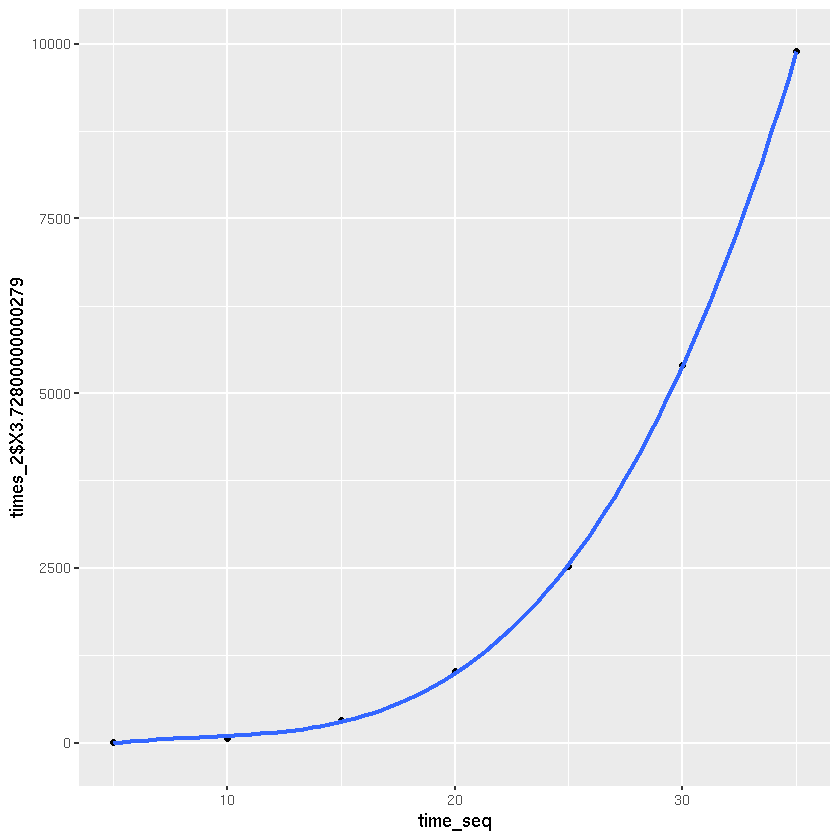

In [469]:
ggplot()+
geom_point(aes(x=time_seq,y=times_2$X3.72800000000279))+
geom_smooth(method="lm",aes(x=time_seq,y=times_2$X3.72800000000279),formula = y~poly(x,3))

In [468]:
predictor_time=lm(times_2$X3.72800000000279~poly(time_seq,3))
summary(predictor_time)


Call:
lm(formula = times_2$X3.72800000000279 ~ poly(time_seq, 3))

Residuals:
      1       2       3       4       5       6       7 
 12.871 -37.144  22.384  24.482 -29.375   4.263   2.519 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         2747.24      12.97  211.80 2.32e-07 ***
poly(time_seq, 3)1  8041.04      34.32  234.31 1.71e-07 ***
poly(time_seq, 3)2  4019.68      34.32  117.13 1.37e-06 ***
poly(time_seq, 3)3   956.42      34.32   27.87 0.000101 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 34.32 on 3 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:  0.9999 
F-statistic: 2.313e+04 on 3 and 3 DF,  p-value: 4.825e-07


In [486]:
times_2=data.frame()
for (x in seq(5,35,5)){
  times_2=rbind(times_2,
  system.time(
    knn(k=x,
        train_data=training_set[1:(x^2),],
        test_data = test_set[1:((x^2)/5),],
        ncores = 56,
        outcome_var = "Rndrng_Prvdr_Type",
        name_var = "Rndrng_NPI",
        mode="prediction",
        sparsity_prp=1,
        scale=T
     )))
}

In [488]:
times_2

X0.180000000000291,X2.34200000000001,X2.59100000000035,X4.50800000000163,X10.5439999999999
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.180,2.342,2.591,4.508,10.544
0.551,2.798,4.595,47.603,41.026
2.140,2.753,14.813,312.631,142.943
6.199,2.824,37.173,923.515,201.547
13.929,3.480,86.411,2292.126,382.334
29.170,3.328,139.683,4849.182,320.119
53.523,4.454,263.081,9069.896,579.694


In [489]:
predictions_time=(seq(5,35,5)^6)/10000
time_seq=seq(5,35,5)^2

Warning message in grid.Call.graphics(C_polygon, x$x, x$y, index):
“semi-transparency is not supported on this device: reported only once per page”


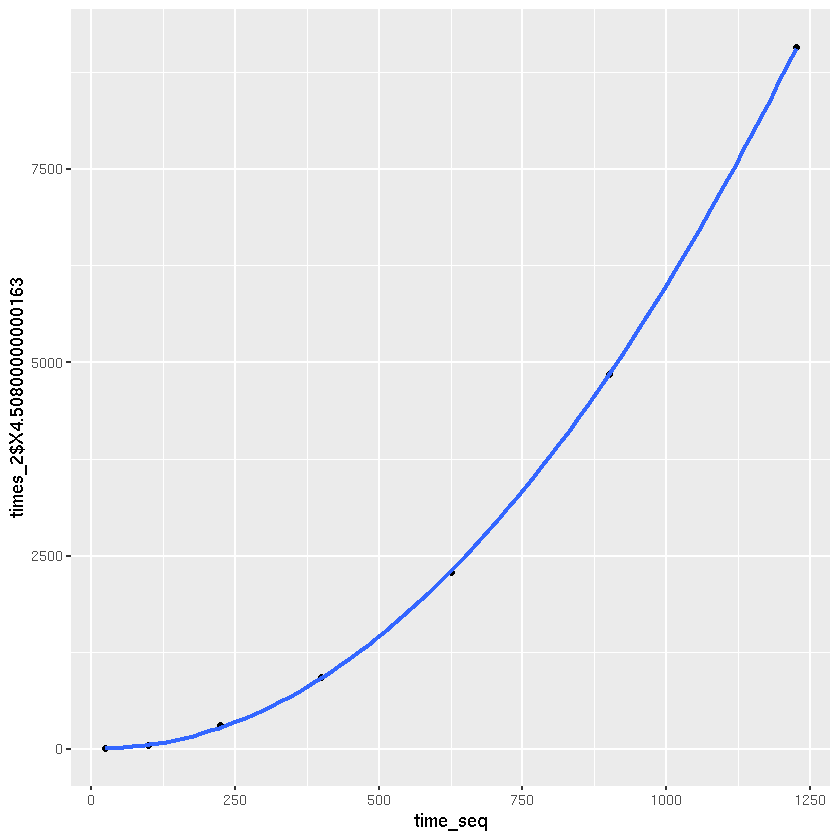

In [491]:
ggplot()+
geom_point(aes(x=time_seq,y=times_2$X4.50800000000163))+
geom_smooth(method="lm",aes(x=time_seq,y=times_2$X4.50800000000163),formula = y~poly(x,2))

In [493]:
predictor_time=lm(times_2$X4.50800000000163~poly(time_seq,2))
summary(predictor_time)


Call:
lm(formula = times_2$X4.50800000000163 ~ poly(time_seq, 2))

Residuals:
       1        2        3        4        5        6        7 
 -9.8867  -8.9461  30.6813   0.2033 -14.3104  -1.0289   3.2875 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        2499.923      6.907   361.9 3.50e-10 ***
poly(time_seq, 2)1 7944.398     18.274   434.7 1.68e-10 ***
poly(time_seq, 2)2 2263.235     18.274   123.8 2.55e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 18.27 on 4 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 1.022e+05 on 2 and 4 DF,  p-value: 3.832e-10
